In [1]:
import pandas as pd
import numpy as np

# Ejercicio 1

Pensamos en usar 20% de test para tener mas confianza en los resultados de nuestros modelos. 10% nos parecio muy bajo (50 datos).

Vamos a usar K-Fold para validar el modelo con el fine-tuning.

(?) usar stratified en test

In [2]:
datos = pd.read_csv("datos/data.csv")
datos = datos.sample(frac=1).reset_index(drop=True) # Permuto las filas al azar x si estaban ordenadas

y = datos['target']
X = datos.iloc[:, :-1]

In [3]:
def desarrollo_evaluacion(X, y, prop_train):
    return X[:int(len(X)*prop_train)], y[:int(len(X)*prop_train)], X[int(len(X)*prop_train):], y[int(len(X)*prop_train):]

In [4]:
X_train, y_train, X_test, y_test = desarrollo_evaluacion(X, y, 0.8)

# Ejercicio 2

In [5]:
from sklearn import tree, model_selection
from sklearn import metrics

In [6]:
arbol = tree.DecisionTreeClassifier(max_depth=3)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

(!) average_precision es ~AUPRC

In [7]:
metricas = ['accuracy', 'roc_auc', 'average_precision']
scores = model_selection.cross_validate(arbol, X_train, y_train, cv = 5, scoring = metricas, return_train_score=True, return_estimator=True, return_indices=True)

In [8]:
for metrica in list(scores.keys())[4:]:
    scores[metrica] = {'permutacion': scores[metrica], 'promedio': np.mean(scores[metrica])}

scores

{'fit_time': array([0.01917505, 0.01879239, 0.01969814, 0.01838112, 0.01945853]),
 'score_time': array([0.00547934, 0.00487185, 0.00470376, 0.00459242, 0.00483823]),
 'estimator': [DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3)],
 'indices': {'train': (array([ 76,  77,  79,  80,  82,  83,  84,  85,  86,  88,  89,  91,  92,
           93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
          106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
          119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
          132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
          145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
          158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
          171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
     

(?) cross_val_predict

In [9]:
pred_folds = np.array([])
real_folds = np.array([])
for i in range(5):
    pred_folds = np.concatenate((pred_folds, scores['estimator'][i].predict(X_train.iloc[scores['indices']['test'][i]])))
    real_folds = np.concatenate((real_folds, y_train[scores['indices']['test'][i]]))

In [10]:
global_scores = {'accuracy': metrics.accuracy_score(real_folds, pred_folds),
                 'AUPRC': metrics.average_precision_score(real_folds, pred_folds),
                 'AUCROC': metrics.roc_auc_score(real_folds, pred_folds)}
global_scores

{'accuracy': 0.6475, 'AUPRC': 0.36125850340136056, 'AUCROC': 0.565190651906519}

In [11]:
grilla = model_selection.ParameterGrid({'max_depth': [3, 5, None], 'criterion': ['gini', 'entropy']})
scores_grilla = []

for params in grilla:
    arbol = tree.DecisionTreeClassifier(**params)
    scores_grilla += [model_selection.cross_validate(arbol, X_train, y_train, cv=5, return_train_score=True)]
    scores_grilla[-1]['promedio_test'] = np.mean(scores_grilla[-1]['test_score'])
    scores_grilla[-1]['promedio_train'] = np.mean(scores_grilla[-1]['train_score'])

In [12]:
[param for param in grilla]

[{'criterion': 'gini', 'max_depth': 3},
 {'criterion': 'gini', 'max_depth': 5},
 {'criterion': 'gini', 'max_depth': None},
 {'criterion': 'entropy', 'max_depth': 3},
 {'criterion': 'entropy', 'max_depth': 5},
 {'criterion': 'entropy', 'max_depth': None}]

In [13]:
scores_grilla

[{'fit_time': array([0.02009034, 0.01914454, 0.01968932, 0.01879048, 0.01990223]),
  'score_time': array([0.00185466, 0.0018878 , 0.00433183, 0.00205374, 0.00202656]),
  'test_score': array([0.6125, 0.7125, 0.6375, 0.6125, 0.6625]),
  'train_score': array([0.7875 , 0.8125 , 0.84375, 0.84375, 0.81875]),
  'promedio_test': 0.6475000000000001,
  'promedio_train': 0.82125},
 {'fit_time': array([0.02740049, 0.0276792 , 0.02745247, 0.02712035, 0.02664423]),
  'score_time': array([0.00188684, 0.00172043, 0.00176692, 0.00179124, 0.00261188]),
  'test_score': array([0.6625, 0.65  , 0.6625, 0.6625, 0.6875]),
  'train_score': array([0.921875, 0.896875, 0.9375  , 0.903125, 0.925   ]),
  'promedio_test': 0.665,
  'promedio_train': 0.9168749999999999},
 {'fit_time': array([0.03219795, 0.0379169 , 0.04372215, 0.05572867, 0.03826618]),
  'score_time': array([0.0017755 , 0.00179815, 0.0020411 , 0.00178385, 0.00226784]),
  'test_score': array([0.6875, 0.65  , 0.6125, 0.6625, 0.7   ]),
  'train_score': a

(!) faltan conclusiones

- los ultimos dan 1 porque tienen altura maxima inf
- decir algo de entropy vs. gini

# Ejercicio 3

In [14]:
from sklearn import neighbors, svm, discriminant_analysis, naive_bayes

In [15]:
tree_params = {'max_depth': [i for i in range(1, 20)], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2']}
knn_params = {'n_neighbors': [i for i in range(1, 20)], 'metric': ['l1', 'l2', 'cosine']}
svm_params = {'C': np.linspace(1, 10, 20), 'tol': [10 ** -i for i in range(1, 6)], 'kernel': ['linear', 'rbf']}
lda_params = {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 1.0]}
naive_params = {'priors': [[i, 1-i] for i in np.linspace(0, 1, 100)]}

In [16]:
modelos = {
    tree.DecisionTreeClassifier: tree_params,
    neighbors.KNeighborsClassifier: knn_params,
    svm.SVC: svm_params,
    discriminant_analysis.LinearDiscriminantAnalysis: lda_params,
    naive_bayes.GaussianNB: naive_params
}

results = {}
mejores = []

for modelo, params in modelos.items():
    search = model_selection.RandomizedSearchCV(estimator=modelo(),
                                       param_distributions=params,
                                       scoring='roc_auc')
    search.fit(X_train, y_train)
    results[modelo] = search.cv_results_
    mejores.append(search.best_estimator_)

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 637, in fit
    self._solve_eigen(
  File "/home/godo/.local/lib

In [17]:
excl = ['params', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_test_score', 'rank_test_score']
for modelo in modelos:
    print(pd.DataFrame(results[modelo]).drop(excl, axis=1).sort_values('mean_test_score', ascending=False))
    print('\n\n')

  param_max_features param_max_depth param_criterion  mean_test_score
1               log2               6            gini         0.605550
2               log2              10         entropy         0.600859
9               sqrt              11        log_loss         0.586116
5               sqrt              13            gini         0.585609
6               log2              18        log_loss         0.570772
3               log2              11            gini         0.567229
7               sqrt               3         entropy         0.566535
4               sqrt               7         entropy         0.556586
8               log2              12         entropy         0.555751
0               log2               6        log_loss         0.520226



  param_n_neighbors param_metric  mean_test_score
6                 8           l1         0.815351
1                 6           l1         0.809179
2                14       cosine         0.796270
9                16       c

In [52]:
for modelo in results:
    print(modelo, max(results[modelo]['mean_test_score']))

<class 'sklearn.tree._classes.DecisionTreeClassifier'> 0.6055497021497022
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> 0.8153506345506345
<class 'sklearn.svm._classes.SVC'> 0.8801473193473195
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> 0.8788081844081844
<class 'sklearn.naive_bayes.GaussianNB'> 0.7966980574980576


In [18]:
for modelo in mejores:
    print(modelo)

DecisionTreeClassifier(max_depth=6, max_features='log2')
KNeighborsClassifier(metric='l1', n_neighbors=8)
SVC(C=6.2105263157894735, tol=0.01)
LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr')
GaussianNB(priors=[0.05050505050505051, 0.9494949494949495])


# Ejercicio 4

Arbol de decision, LDA, SVM

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ValidationCurveDisplay

Text(0.5, 1.0, 'Arbol de decision')

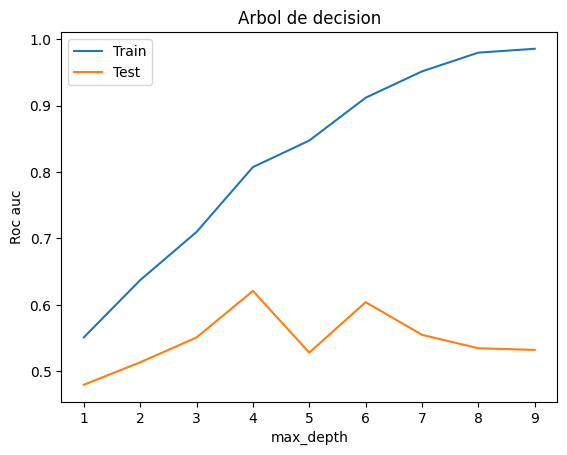

In [20]:
ValidationCurveDisplay.from_estimator(mejores[0], X_train, y_train, param_name='max_depth', param_range=[i for i in range(10)], std_display_style=None, scoring='roc_auc')
plt.title('Arbol de decision')

aumentar max depth hace que el modelo overfittee. Sin embargo, en evaluacion la performance no mejora.

Text(0.5, 1.0, 'SVM')

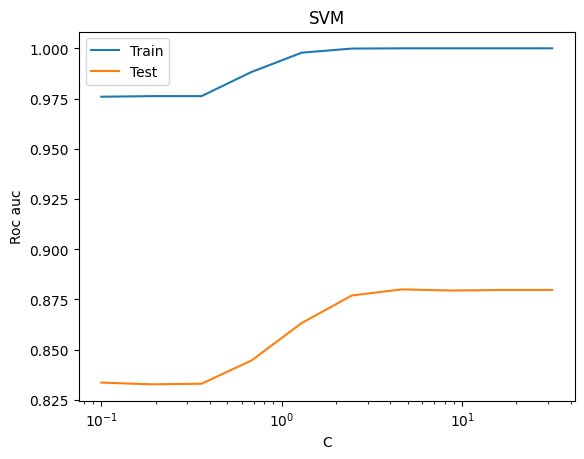

In [29]:
ValidationCurveDisplay.from_estimator(mejores[2], X_train, y_train, param_name='C', param_range=np.logspace(-1, 1.5, 10), std_display_style=None, scoring='roc_auc')
plt.title('SVM')

A mayores valores de C el modelo es menos "regular". SVM se satura alrededor de C=5 y el score de test converge (ademas train llega al maximo, 1).

In [22]:
from sklearn.model_selection import LearningCurveDisplay

In [23]:
# Usamos siempre el mismo conjunto de validacion (el ultimo 20%, porque permutamos los datos)
train_test_indices = [([i for i in range(320)], [i for i in range(320, 400)])]

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_resp

Text(0.5, 1.0, 'Arbol de decision')

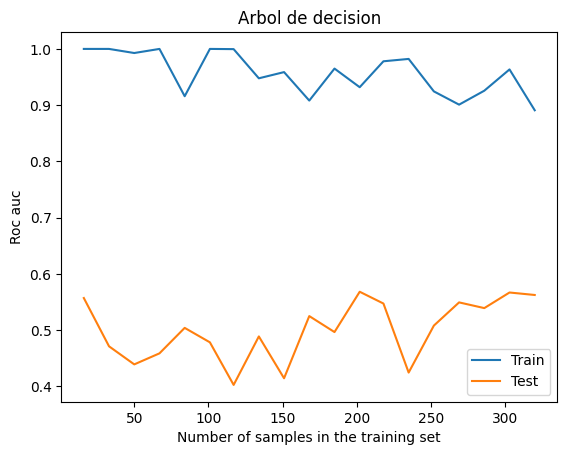

In [24]:
LearningCurveDisplay.from_estimator(mejores[0], X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), scoring='roc_auc', cv=train_test_indices)
plt.title('Arbol de decision')

Para el arbol de decision mas datos no mejora el rendimiento. El modelo ya separo el espacio lo mejor que pudo con los parametros dados.

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "/home/godo/.local/lib/

Text(0.5, 1.0, 'SVM')

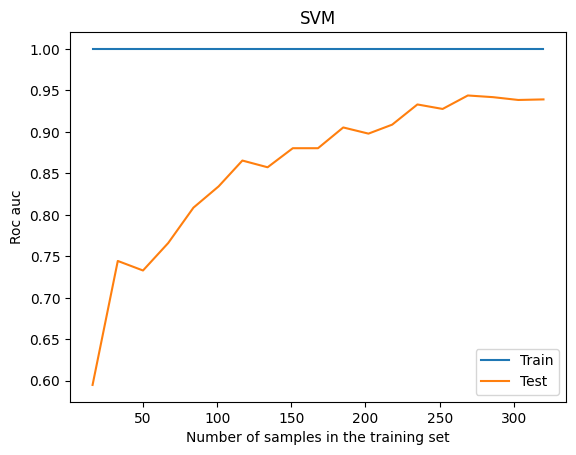

In [25]:
LearningCurveDisplay.from_estimator(mejores[2], X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), scoring='roc_auc', cv=train_test_indices)
plt.title('SVM')

El grafico parece haber convergido. Sin embargo, es creciente hasta el final asi que podria mejorar con mas datos de entrenamiento.

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 581, in fit
    X, y = self._validate_data(
  File "/home/godo/.

Text(0.5, 1.0, 'LDA')

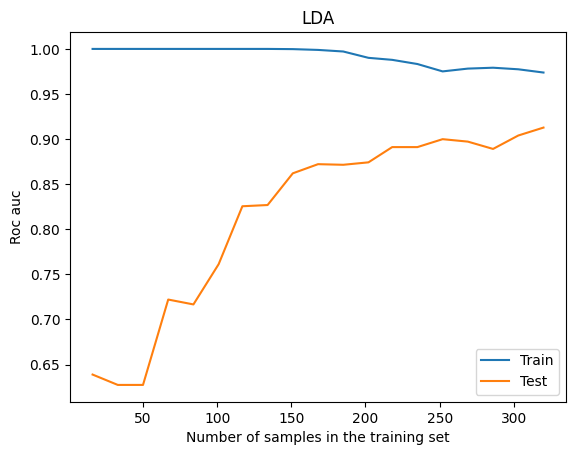

In [31]:
LearningCurveDisplay.from_estimator(mejores[3], X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), scoring='roc_auc', cv=train_test_indices)
plt.title('LDA')

Para LDA la curva de aprendizaje tambien es creciente, asi que el modelo no llego a overfitear (baja varianza o sesgo alto). Con mas datos puede mejorar la performance.

## Random forest

In [33]:
from sklearn import ensemble

In [34]:
random_forest = ensemble.RandomForestClassifier(n_estimators=200)

(!) usar randomizedsearchcv para los otros parametros

In [44]:
search = model_selection.RandomizedSearchCV(random_forest, param_distributions={'max_depth': [i for i in range(20)], 'criterion': ['gini', 'entropy', 'log_loss']})
search.fit(X_train, y_train)
pd.DataFrame(search.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.554229,0.005844,0.007430,0.000228,19,log_loss,"{'max_depth': 19, 'criterion': 'log_loss'}",0.7375,0.7250,0.7125,0.7125,0.6750,0.7125,0.020917,2
1,0.532605,0.002775,0.007291,0.000251,8,log_loss,"{'max_depth': 8, 'criterion': 'log_loss'}",0.7125,0.7000,0.7125,0.7125,0.6875,0.7050,0.010000,6
2,0.479929,0.006151,0.007312,0.000169,10,gini,"{'max_depth': 10, 'criterion': 'gini'}",0.7000,0.7000,0.7250,0.7000,0.6875,0.7025,0.012247,7
3,0.380872,0.006012,0.007161,0.000363,5,gini,"{'max_depth': 5, 'criterion': 'gini'}",0.6875,0.7000,0.6750,0.7000,0.6875,0.6900,0.009354,10
4,0.531206,0.006157,0.007168,0.000214,17,log_loss,"{'max_depth': 17, 'criterion': 'log_loss'}",0.7000,0.7125,0.6875,0.7250,0.7000,0.7050,0.012748,5
5,0.490127,0.007924,0.007079,0.000152,12,gini,"{'max_depth': 12, 'criterion': 'gini'}",0.7500,0.7125,0.7125,0.7000,0.7125,0.7175,0.016956,1
6,0.540837,0.008866,0.007155,0.000152,9,log_loss,"{'max_depth': 9, 'criterion': 'log_loss'}",0.7625,0.7125,0.6875,0.7000,0.6750,0.7075,0.030208,4
7,0.475862,0.006603,0.007340,0.000220,9,gini,"{'max_depth': 9, 'criterion': 'gini'}",0.7375,0.7000,0.7000,0.7250,0.6875,0.7100,0.018371,3
8,0.490821,0.006007,0.006948,0.000145,6,log_loss,"{'max_depth': 6, 'criterion': 'log_loss'}",0.7250,0.7125,0.6875,0.7125,0.6750,0.7025,0.018371,7
9,0.413791,0.003153,0.007127,0.000182,6,gini,"{'max_depth': 6, 'criterion': 'gini'}",0.6875,0.7125,0.7000,0.7250,0.6750,0.7000,0.017678,9


Text(0.5, 1.0, 'Random forest')

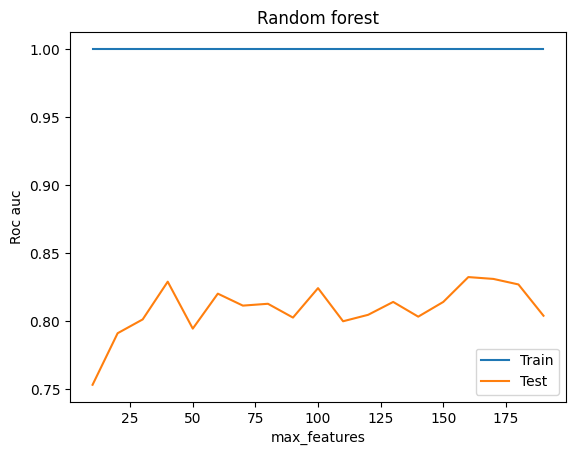

In [47]:
np.random.seed(123)
random_forest = search.best_estimator_
ValidationCurveDisplay.from_estimator(random_forest, X_train, y_train, param_name='max_features', param_range=[i for i in range(0, 200, 10)], std_display_style=None, cv=train_test_indices, scoring='roc_auc')
plt.title('Random forest')

Para los datos, max_features no mejora el rendimiento del random forest.

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_resp

Text(0.5, 1.0, 'Random forest')

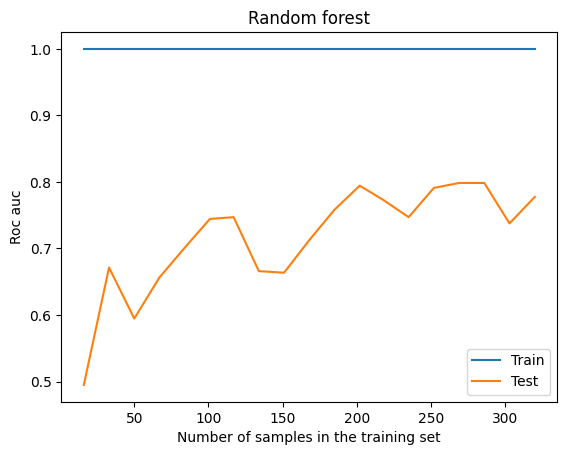

In [49]:
np.random.seed(123)
LearningCurveDisplay.from_estimator(random_forest, X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), cv=train_test_indices, scoring='roc_auc')
plt.title('Random forest')

El rendimiento en evaluacion mejora con mas instancias.

## Ejercicio 5

In [57]:
X_held_out = pd.read_csv('datos/X_held_out.csv')
X_held_out

,v000,v001,v002,v003,v004,v005,v006,v007,v008,v009,...,v190,v191,v192,v193,v194,v195,v196,v197,v198,v199
0,-1.106151,-5.611131,2.712683,-0.529517,-3.831639,0.672653,5.333427,0.108881,0.069763,0.609721,...,-2.388832,-3.575021,-0.195262,-1.329819,-0.615811,-0.149399,0.976335,0.245581,-1.301849,0.729059
1,-0.266336,-2.918979,-1.006739,-0.096504,-3.009074,0.297644,-16.247286,0.011176,1.517002,-0.145927,...,-0.289372,-6.945991,1.973832,1.709684,-0.637233,-1.125183,-0.388908,0.645088,0.258491,1.538284
2,-0.139785,-5.756247,3.459090,3.011876,0.487198,0.533537,-33.141916,0.520467,-1.259532,1.434195,...,0.452060,-1.663599,0.163550,-0.889856,-1.884028,-0.780582,-2.693877,0.507226,0.862945,-0.655356
3,-0.185081,0.841544,9.382768,6.086935,2.288472,-2.844599,41.278200,-0.247986,0.537805,-0.519840,...,-1.990920,7.234289,-0.541081,-0.974709,-0.196730,-0.831564,-0.664984,-0.249332,-0.477191,-1.193948
4,0.971970,-2.962117,4.602942,1.043721,-0.016791,-0.772379,1.816865,-0.980162,-0.114072,-0.864194,...,1.525412,23.118892,-0.503892,0.172780,-0.798356,-0.368429,0.277803,-0.428431,1.802202,0.426170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.566337,0.512514,4.594405,-2.705414,1.890147,0.742073,-18.456021,1.102414,0.891122,0.311605,...,5.517851,11.471693,0.093960,-0.232578,-0.309831,-0.028813,-0.938506,0.155053,0.123868,-1.328063
496,0.700373,-6.066661,-6.075214,-1.155673,-0.657031,0.186253,-4.231492,-0.619254,-0.791117,0.798235,...,-4.989733,-10.175124,-1.455930,1.057059,-1.123295,-0.924695,-0.724669,-0.795370,-0.270905,1.506184
497,0.777344,-7.176908,3.354252,3.942897,-1.569569,1.604099,6.729852,0.741177,0.995905,1.283633,...,1.544407,18.577471,-0.027807,0.694708,-0.273394,0.481717,0.916152,-0.592327,-0.988314,1.642040
498,0.052583,-2.996524,-5.692944,1.778892,-3.468169,-0.881855,-23.259602,0.980070,-2.928452,-0.384283,...,2.657637,-4.861505,0.976821,0.030431,-1.901067,1.638674,1.400128,-0.306662,0.500872,-0.769428


In [83]:
params_svm = mejores[2].get_params()
params_svm['probability'] = True

In [88]:
svm_proba = svm.SVC(**params_svm)
svm_proba.fit(X_train, y_train)

SVC(C=6.2105263157894735, probability=True, tol=0.01)

# Tuning: SVM pistero

In [94]:
svm_eval = np.round(svm_proba.predict_proba(X_held_out)[:, 0], 4)

In [93]:
lda_eval = np.round(mejores[3].predict_proba(X_held_out)[:, 0], 4)

In [96]:
svm_params = {'C': np.linspace(-10, 10, 100), 'tol': np.logspace(-10, 2, 100), 'kernel': ['linear', 'rbf']}

In [99]:
search_svm = model_selection.RandomizedSearchCV(svm.SVC(), param_distributions=svm_params, scoring='roc_auc')
search_svm.fit(X_train, y_train)

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/godo/.local/lib/python

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': array([-10.        ,  -9.7979798 ,  -9.5959596 ,  -9.39393939,
        -9.19191919,  -8.98989899,  -8.78787879,  -8.58585859,
        -8.38383838,  -8.18181818,  -7.97979798,  -7.77777778,
        -7.57575758,  -7.37373737,  -7.17171717,  -6.96969697,
        -6.76767677,  -6.56565657,  -6.36363636,  -6.16161616,
        -5.95959596,  -5.75757576,  -5.55555556,  -5.35353535,
        -5.1...
       1.62975083e-01, 2.15443469e-01, 2.84803587e-01, 3.76493581e-01,
       4.97702356e-01, 6.57933225e-01, 8.69749003e-01, 1.14975700e+00,
       1.51991108e+00, 2.00923300e+00, 2.65608778e+00, 3.51119173e+00,
       4.64158883e+00, 6.13590727e+00, 8.11130831e+00, 1.07226722e+01,
       1.41747416e+01, 1.87381742e+01, 2.47707636e+01, 3.27454916e+01,
       4.32876128e+01, 5.72236766e+01, 7.56463328e+01, 1.00000000e+02])},
                   scoring='roc_auc')

In [ ]:
search_svc.cv_results_